In [1]:
# AC-GAN Github Example: https://github.com/clvrai/ACGAN-PyTorch/

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torch.utils import data as t_data
import torchvision.datasets as datasets
from torchvision import transforms
import torch.nn.functional as F

In [3]:
# Config

n_epochs = 1000
learning_rate = 0.005
momentum = 0.5
print_interval = 10
batch_size = 4
d_steps = 100
g_steps = 100

transform = transforms.Compose([
                               transforms.ToTensor(),
                               transforms.Normalize(
                                 (0.1307,), (0.3081,))])

In [4]:
def get_noise():
    return torch.rand(batch_size,49)

def plot_img(array,number=None):
    array = array.detach()
    array = array.reshape(28,28)
    
    plt.imshow(array,cmap='binary')
    plt.xticks([])
    plt.yticks([])
    if number:
        plt.xlabel(number,fontsize='x-large')
    plt.show()

In [5]:
trainset = datasets.MNIST(root='./data', train=True,
                                        download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(
                              datasets.MNIST('../data/', train=True, download=True,
                                 transform=transform),
                              batch_size=batch_size, shuffle=True)

In [6]:
class generator(nn.Module):
    
    def __init__(self):
        
        super(generator, self).__init__()
        
        self.lin1 = nn.Linear(49, 49 * 32)
        self.convt = nn.ConvTranspose2d(32, 32, 4, stride=2, padding=1)
        self.conv = nn.Conv2d(32, 1, 5, padding=2)
        
    def forward(self, x):
        x = F.leaky_relu(self.lin1(x))
        x = x.reshape(batch_size, 32, 7, 7)  # 7x7
        x = F.leaky_relu(self.convt(x))  # 14x14
        x = F.leaky_relu(self.convt(x))  # 28x28
        x = F.sigmoid(self.conv(x))
        return x

In [7]:
class discriminator(nn.Module):
    
    def __init__(self):
        
        super(discriminator, self).__init__()
        
        self.conv1 = nn.Conv2d(1, 16, 3, padding=1)
        self.conv2 = nn.Conv2d(16, 16, 3, padding=1)
        self.flatten = nn.Flatten()
        self.lin1 = nn.Linear(16*28*28, 300)
        self.lin2 = nn.Linear(300, 1)
        
    def forward(self, x):
        x = F.dropout2d(F.leaky_relu(self.conv1(x)), p=0.4)
        x = F.dropout2d(F.leaky_relu(self.conv2(x)), p=0.4)
        x = x.reshape(batch_size, 16 * 28 * 28)
        x = F.relu(self.lin1(x))
        x = F.sigmoid(self.lin2(x))
        return x

In [8]:
dis = discriminator()
gen = generator()

criteriond1 = nn.BCELoss()
optimizerd1 = optim.SGD(dis.parameters(), lr=learning_rate, momentum=momentum)

criteriond2 = nn.BCELoss()
optimizerd2 = optim.SGD(gen.parameters(), lr=learning_rate, momentum=momentum)

/home/calvinhirsch/Augmentation-and-Adversarial-Example-Cross-Analysis/venv/lib/python3.6/site-packages/torch/nn/functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


========0========
Real Loss: 3.676183918764881
Fake Loss: 4.729586929986908


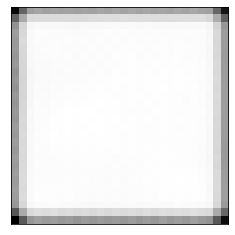




========10========
Real Loss: 0.442560961914225
Fake Loss: 1.4458698348078265


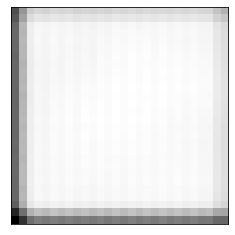




========20========
Real Loss: 0.035386850015747484
Fake Loss: 0.36034117290212464


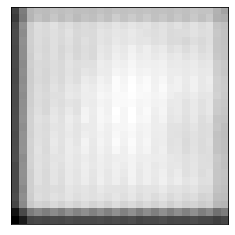




========30========
Real Loss: 0.1485204880613793
Fake Loss: 0.19552943889630825


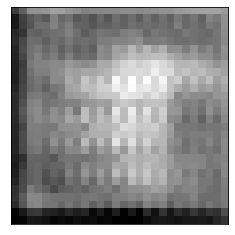




========40========
Real Loss: 0.07872161250984888
Fake Loss: 0.07005708072036043


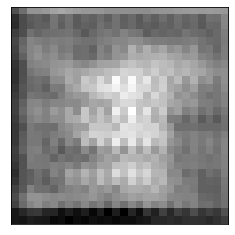

KeyboardInterrupt: 

In [9]:
running_fake_loss = 0.0
running_real_loss = 0.0

for epoch in range(n_epochs + 1):
    # training discriminator
    for d_step in range(d_steps):
        dis.zero_grad()
        
        # training discriminator on real data
        for inp_real,t in train_loader:
            inp_real_x = inp_real
            target = t
            break
        
        dis_real_out = dis(inp_real_x)
        dis_real_loss = criteriond1(dis_real_out, Variable(torch.zeros(batch_size, 1)))
        dis_real_loss.backward()
        
        running_real_loss += dis_real_loss.item()

        # training discriminator on data produced by generator
        inp_fake_x_gen = get_noise()
        #output from generator is generated        
        dis_inp_fake_x = gen(inp_fake_x_gen).reshape(batch_size, 1, 28, 28)
        dis_fake_out = dis(dis_inp_fake_x)
        dis_fake_loss = criteriond1(dis_fake_out,
                                Variable(torch.zeros(batch_size,1)))
        dis_fake_loss.backward()
        
        running_fake_loss += dis_fake_loss.item()

        optimizerd1.step()
        
        
            
    # training generator
    for g_step in range(g_steps):
        gen.zero_grad()
        
        #generating data for input for generator
        gen_inp = get_noise()
        
        gen_out = gen(gen_inp)
        
        dis_out_gen_training = dis(gen_out)
        gen_loss = criteriond2(dis_out_gen_training,
                               Variable(torch.ones(batch_size,1)))
        gen_loss.backward()
        
        optimizerd2.step()
        
    if epoch%print_interval==0:
        print("========" + str(epoch) + "========")
        print("Real Loss: " + str(running_real_loss))
        print("Fake Loss: " + str(running_fake_loss))
        running_real_loss = 0.0
        running_fake_loss = 0.0
        plot_img(gen_out[0])
        print("\n\n")